In [13]:
from qadence import (feature_map, hea, Z, QuantumModel, add, QuantumCircuit, 
                     kron, FeatureParameter, RX, RZ, VariationalParameter, RY,
                     chain)
import matplotlib.pyplot as plt
import torch

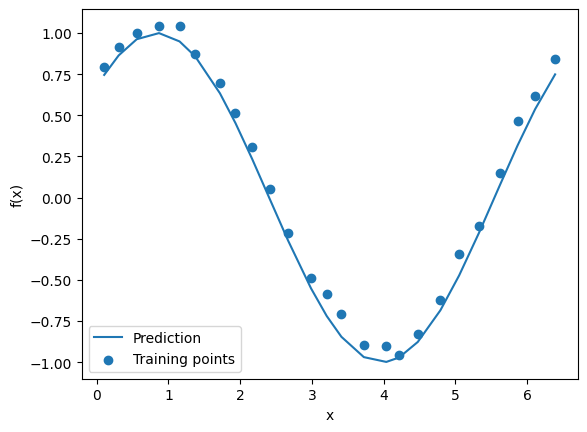

-0.8336712313052639


In [21]:
def vqc_fit(n_qubits, n_epochs, aops = 2):
    fm = feature_map(n_qubits, param = "x")
    x = FeatureParameter("x")
    fm = kron(RX(0, x))

    if n_qubits == 1:
        assert aops in [1, 2, 3]
        # aops is the number of rotations to use in the ansatz.
        # 1 seems to be enough; the fit parameter is then the phi we want.
        thetas = [VariationalParameter(f"theta{i}") for i in range(aops)]
        RS = [RX, RY, RZ]
        RS = RS[:aops]
        ansatz = chain(R(0, theta) for R, theta in zip(RS, thetas))
    else:
        ansatz = hea(n_qubits, depth = 2)

    obs = add(Z(i) for i in range(n_qubits))
    block = fm * ansatz

    circuit = QuantumCircuit(n_qubits, block)
    model = QuantumModel(circuit, observable = obs)

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)

    for epoch in range(n_epochs):
        optimizer.zero_grad()
        loss = loss_fn(x_train, y_train, model, criterion)
        loss.backward()
        optimizer.step()
        y_pred = model.expectation({"x": x_train}).squeeze().detach()

    return model, y_pred

def loss_fn(x_train, y_train, model, criterion):
    output = model.expectation({"x": x_train}).squeeze()
    loss = criterion(output, y_train)
    return loss

def data_from_file(path):
    with open(path, "r") as file:
        points = [tuple(map(float, line.split())) for line in file]

    x_train = torch.Tensor([point[0] for point in points])
    y_train = torch.Tensor([point[1] for point in points])
    return x_train, y_train

def plot(x_train, y_train, y_pred):
    plt.plot(x_train, y_pred, label = "Prediction")
    plt.scatter(x_train, y_train, label = "Training points")
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.legend()
    plt.show()

def scipy_verification(x_data, y_data):
    def model(x, A, phi, B):
        return A * np.cos(x + phi) + B
    params, covariance = curve_fit(model, x_data, y_data, p0=[2, 0, 1])  
    A_fitted, phi_fitted, B_fitted = params
    print(f"Fitted Parameters: A = {A_fitted}, phi = {phi_fitted}, B = {B_fitted}")
    plt.scatter(x_data, y_data, label="Data", color='red')
    plt.plot(x_data, model(x_data, *params), label="Fitted model", color='blue')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()

quantum = True
show = True
x_train, y_train = data_from_file("dataset_1_a.txt")

if quantum: 
    n_qubits = 1
    model, y_pred = vqc_fit(n_qubits, n_epochs = 100, aops = 1)
    if show:
        plot(x_train, y_train, y_pred)
    vparams = model.vparams
    print(vparams['theta0'].item())
else: 
    scipy_verification(x_train, y_train)

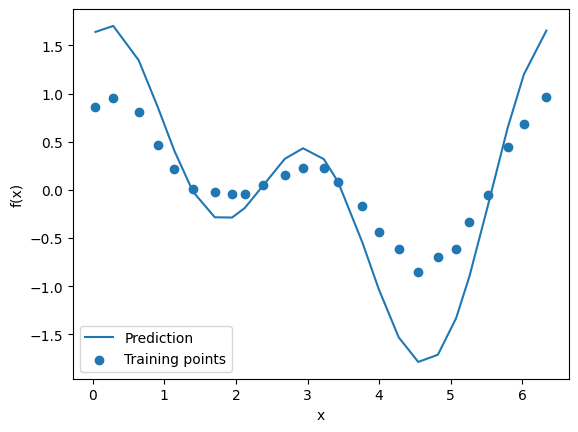

-0.9116850594767848
-0.10441493298937622


In [29]:
def vqc_fit(n_qubits, n_epochs):
    fm = feature_map(n_qubits, param = "x")
    x = FeatureParameter("x")
    fm = kron(RX(i, (i+1)*x) for i in range(n_qubits))

    theta1 = VariationalParameter("theta1")
    theta2 = VariationalParameter("theta2")
    ansatz = chain(RX(0, theta1), RX(1,theta2))

    obs = add(Z(i) for i in range(n_qubits))
    block = fm * ansatz

    circuit = QuantumCircuit(n_qubits, block)
    model = QuantumModel(circuit, observable = obs)

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)

    for epoch in range(n_epochs):
        optimizer.zero_grad()
        loss = loss_fn(x_train, y_train, model, criterion)
        loss.backward()
        optimizer.step()
        y_pred = model.expectation({"x": x_train}).squeeze().detach()

    return model, y_pred

def loss_fn(x_train, y_train, model, criterion):
    output = model.expectation({"x": x_train}).squeeze()
    loss = criterion(output, y_train)
    return loss

def data_from_file(path):
    with open(path, "r") as file:
        points = [tuple(map(float, line.split())) for line in file]

    x_train = torch.Tensor([point[0] for point in points])
    y_train = torch.Tensor([point[1] for point in points])
    return x_train, y_train

def plot(x_train, y_train, y_pred):
    plt.plot(x_train, y_pred, label = "Prediction")
    plt.scatter(x_train, y_train, label = "Training points")
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.legend()
    plt.show()

def scipy_verification(x_data, y_data):
    def model(x, A, phi, B):
        return A * np.cos(x + phi) + B
    params, covariance = curve_fit(model, x_data, y_data, p0=[2, 0, 1])  
    A_fitted, phi_fitted, B_fitted = params
    print(f"Fitted Parameters: A = {A_fitted}, phi = {phi_fitted}, B = {B_fitted}")
    plt.scatter(x_data, y_data, label="Data", color='red')
    plt.plot(x_data, model(x_data, *params), label="Fitted model", color='blue')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()

quantum = True
show = True
x_train, y_train = data_from_file("dataset_1_b.txt")

if quantum: 
    n_qubits = 2
    model, y_pred = vqc_fit(n_qubits, n_epochs = 100)
    if show:
        plot(x_train, y_train, y_pred)
    vparams = model.vparams
    print(vparams['theta1'].item())
    print(vparams['theta2'].item())
else: 
    scipy_verification(x_train, y_train)